Zpracovávám cv05_robotS.bmp...


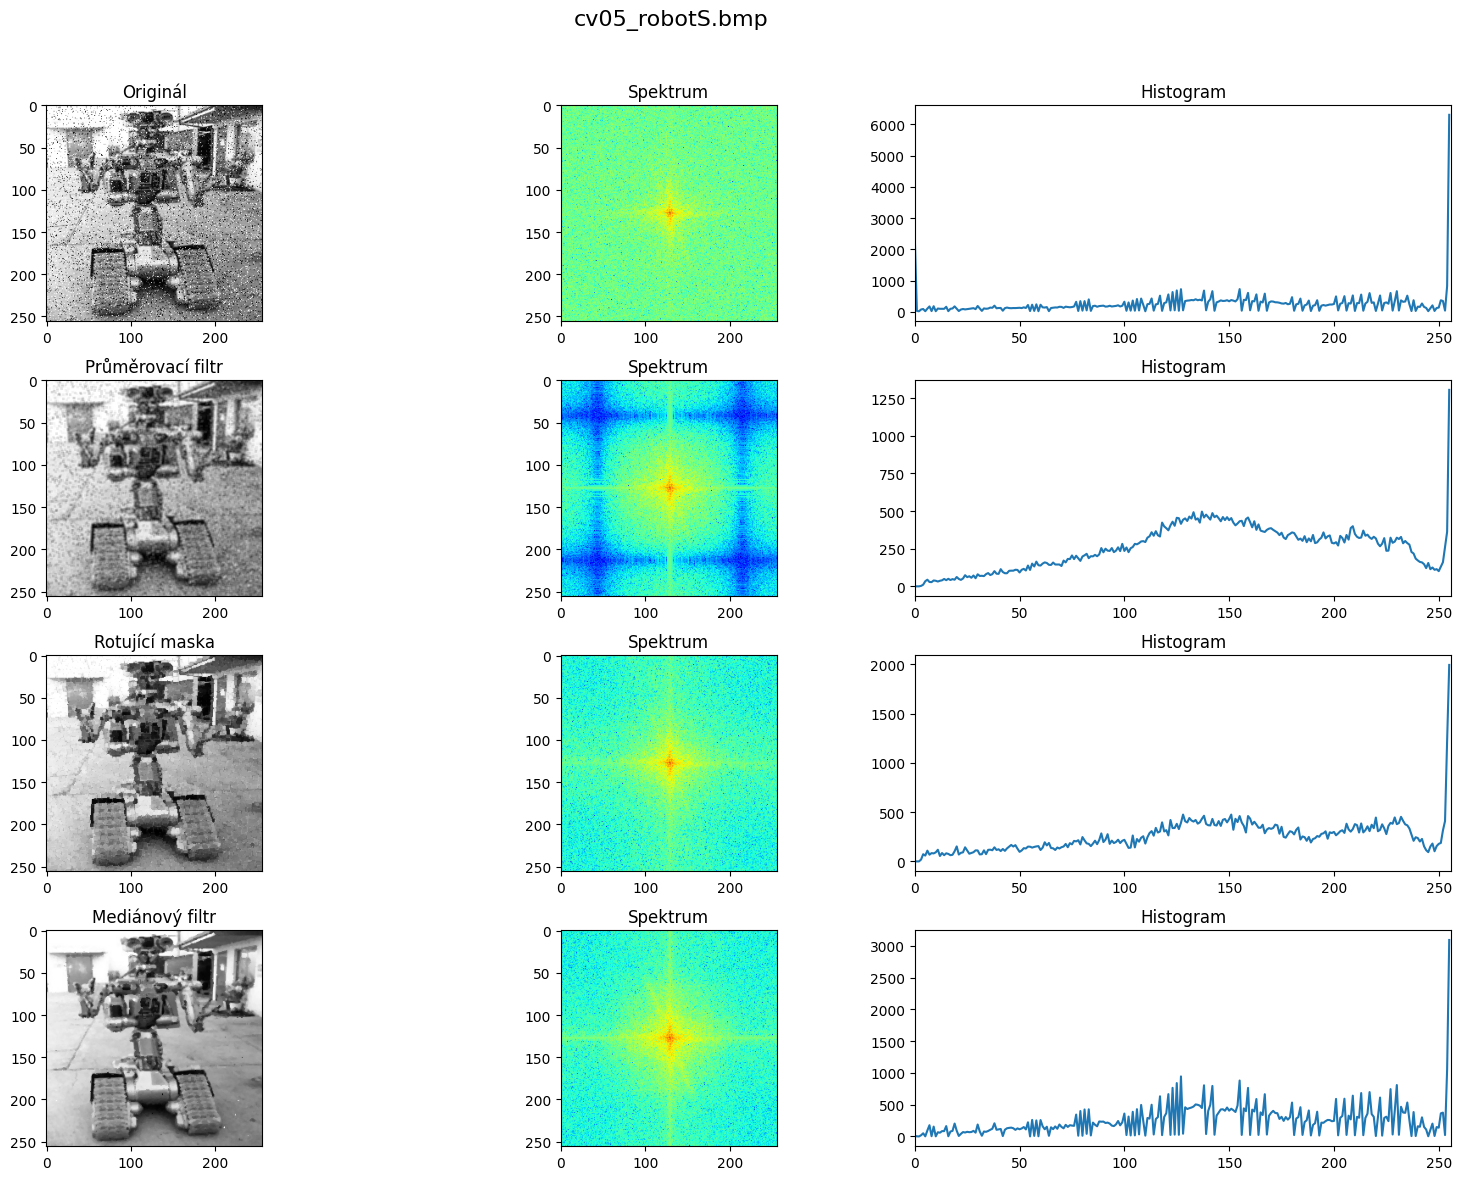

Zpracovávám cv05_PSS.bmp...


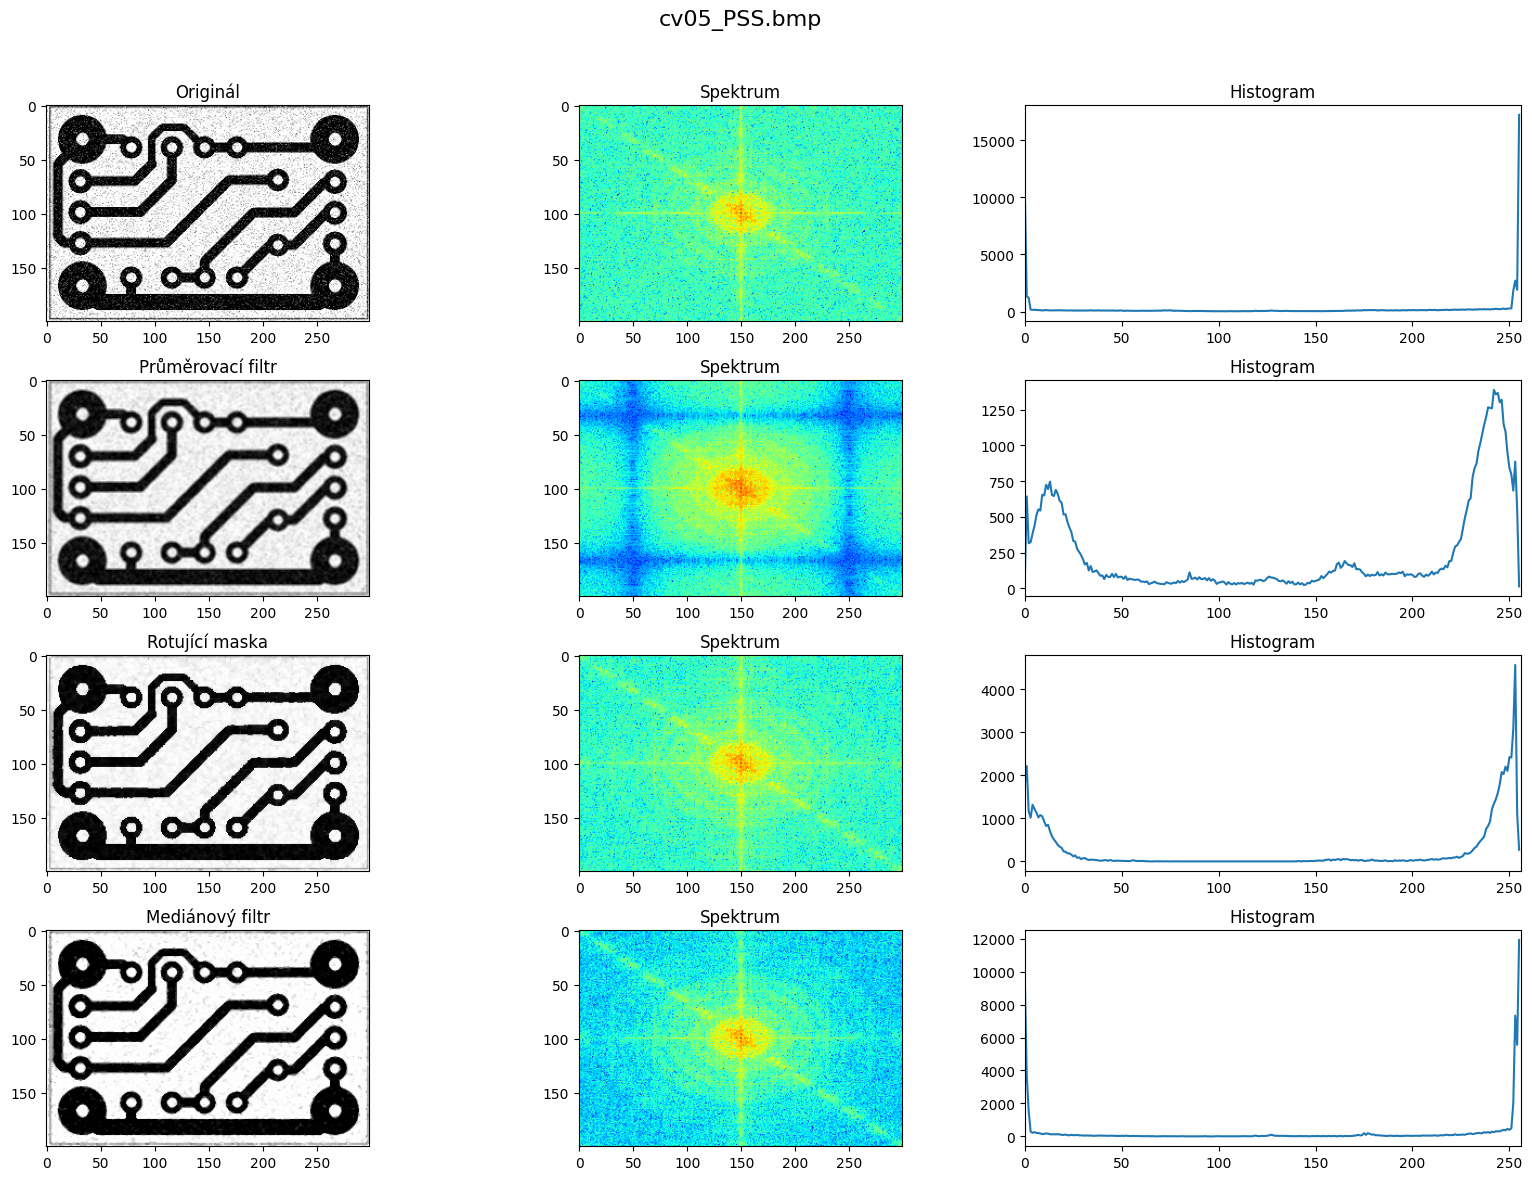

In [3]:
# made by Martin "Granc3k" Šimon, Jakub "Parrot2" Keršláger
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt


def crop(image, x, y, size):
    # Cutne část obrazu o velikosti size se středem v bodě (x, y)
    # Zajistí, aby výřez nepřesáhl hranice obrazu.
    top = max(y - size // 2, 0)
    bottom = min(y + size // 2 + 1, image.shape[0])
    left = max(x - size // 2, 0)
    right = min(x + size // 2 + 1, image.shape[1])
    return image[top:bottom, left:right]


def average_with_rotating_mask(image, mask_size=3):
    # Rotující maska
    output = np.zeros(image.shape, dtype=np.uint8)

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # Create seznamu sousedních oblastí
            masks = [
                crop(image, x + dx, y + dy, mask_size)
                for dx in [-1, 0, 1]
                for dy in [-1, 0, 1]
                if dx or dy
            ]

            # Filtr pouze neprázdné oblasti
            valid_masks = [m for m in masks if m.size > 0]
            if valid_masks:
                # Calc varianci pro každou oblast a vybere tu s nejnižší
                variances = [np.var(m) for m in valid_masks]
                output[y, x] = np.mean(valid_masks[np.argmin(variances)])

    return output


def compute_histogram(image):
    # Calc histogramu
    return cv2.calcHist([image], [0], None, [256], [0, 256])


def process_image(image_path, title):
    # Process obrazu pomocí různých metod filtrování a zobrazí výsledky.
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Chyba při načítání obrázku: {image_path}")
        return

    # Průměrovací filtr (konvoluce s průměrovacím jádrem)
    kernel = np.ones((3, 3), dtype=np.float32) / 9
    mean_filtered = cv2.filter2D(image, -1, kernel)

    # Rotující maska
    rotating_mask_filtered = average_with_rotating_mask(image)

    # Mediánový filtr
    median_filtered = cv2.medianBlur(image, 3)

    # Create grafu s výsledky
    fig, axes = plt.subplots(4, 3, figsize=(16, 12))
    fig.suptitle(f"{title}", fontsize=16)

    for i, (img, label) in enumerate(
        zip(
            [image, mean_filtered, rotating_mask_filtered, median_filtered],
            ["Originál", "Průměrovací filtr", "Rotující maska", "Mediánový filtr"],
        )
    ):
        # Print původní a zpracované obrazy
        axes[i, 0].imshow(img, cmap="gray")
        axes[i, 0].set_title(label)

        # Calc a print amplitudové spektra
        spectrum = np.fft.fftshift(np.fft.fft2(img))
        axes[i, 1].imshow(np.log(np.abs(spectrum) + 1), cmap="jet")
        axes[i, 1].set_title("Spektrum")

        # Calc a print histogramů
        hist = compute_histogram(img)
        axes[i, 2].plot(hist)
        axes[i, 2].set_title("Histogram")
        axes[i, 2].set_xlim([0, 256])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


def main():
    # Main fce
    data_path = Path("./data")
    images = ["cv05_robotS.bmp", "cv05_PSS.bmp"]

    for img in images:
        print(f"Zpracovávám {img}...")
        process_image(data_path / img, img)


if __name__ == "__main__":
    main()